In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.ToTensor()

def psnr(sr, hr):
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))


def compare_sr_models(
    hr_path,
    srcnn_model,
    edsr_model,
    scale=4
):
    srcnn_model.eval()
    edsr_model.eval()

    # LOAD HR
    hr_img = Image.open(hr_path).convert("RGB")
    hr_tensor = to_tensor(hr_img).unsqueeze(0).to(device)

    # GENERATE LR SYNTHETIC
    lr_img = hr_img.resize(
        (hr_img.width // scale, hr_img.height // scale),
        Image.BICUBIC
    )
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    # BICUBIC UPSCALE
    bicubic_tensor = F.interpolate(
        lr_tensor,
        scale_factor=scale,
        mode="bicubic",
        align_corners=False
    )

    # SRCNN
    with torch.no_grad():
        srcnn_sr = srcnn_model(bicubic_tensor)

    # EDSR
    with torch.no_grad():
        edsr_sr = edsr_model(lr_tensor)

    # TO NUMPY
    hr_np       = hr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    bicubic_np  = bicubic_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    srcnn_np    = srcnn_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    edsr_np     = edsr_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    lr_np       = lr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # PSNR
    psnr_bic  = psnr(bicubic_np, hr_np)
    psnr_src  = psnr(srcnn_np, hr_np)
    psnr_edsr = psnr(edsr_np, hr_np)

    print(" PSNR RESULTS (Synthetic LR)")
    print(f"  Bicubic : {psnr_bic:.2f} dB")
    print(f"  SRCNN   : {psnr_src:.2f} dB")
    print(f"  EDSR    : {psnr_edsr:.2f} dB")

    # DISPLAY
    titles = [
        "LR (Synthetic)",
        f"Bicubic\n{psnr_bic:.2f} dB",
        f"SRCNN\n{psnr_src:.2f} dB",
        f"EDSR\n{psnr_edsr:.2f} dB",
        "HR (Ground Truth)"
    ]

    images = [lr_np, bicubic_np, srcnn_np, edsr_np, hr_np]

    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.ToTensor()

def psnr(sr, hr):
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))


def compare_sr_models(
    hr_path,
    srcnn_model,
    edsr_model,
    scale=4
):
    srcnn_model.eval()
    edsr_model.eval()

    # LOAD HR
    hr_img = Image.open(hr_path).convert("RGB")
    hr_tensor = to_tensor(hr_img).unsqueeze(0).to(device)

    # GENERATE LR SYNTHETIC
    lr_img = hr_img.resize(
        (hr_img.width // scale, hr_img.height // scale),
        Image.BICUBIC
    )
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    # BICUBIC UPSCALE
    bicubic_tensor = F.interpolate(
        lr_tensor,
        scale_factor=scale,
        mode="bicubic",
        align_corners=False
    )

    # SRCNN
    with torch.no_grad():
        srcnn_sr = srcnn_model(bicubic_tensor)

    # EDSR
    with torch.no_grad():
        edsr_sr = edsr_model(lr_tensor)

    # TO NUMPY
    hr_np       = hr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    bicubic_np  = bicubic_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    srcnn_np    = srcnn_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    edsr_np     = edsr_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    lr_np       = lr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # PSNR
    psnr_bic  = psnr(bicubic_np, hr_np)
    psnr_src  = psnr(srcnn_np, hr_np)
    psnr_edsr = psnr(edsr_np, hr_np)

    print(" PSNR RESULTS (Synthetic LR)")
    print(f"  Bicubic : {psnr_bic:.2f} dB")
    print(f"  SRCNN   : {psnr_src:.2f} dB")
    print(f"  EDSR    : {psnr_edsr:.2f} dB")

    # DISPLAY
    titles = [
        "LR (Synthetic)",
        f"Bicubic\n{psnr_bic:.2f} dB",
        f"SRCNN\n{psnr_src:.2f} dB",
        f"EDSR\n{psnr_edsr:.2f} dB",
        "HR (Ground Truth)"
    ]

    images = [lr_np, bicubic_np, srcnn_np, edsr_np, hr_np]

    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [6]:
from src.utils.models_architecture import SRCNN, EDSR

checkpoint = torch.load(
    "src/models/checkpoints/SRCNN/best_srcnn.pth",
    map_location=device
)

srcnn = SRCNN().to(device)
srcnn.load_state_dict(checkpoint["model"])
srcnn.eval()

print("✔ SRCNN loaded correctly")

checkpoint = torch.load(
    "src/models/checkpoints/EDSR/best_EDSR.pth",
    map_location=device
)

edsr = EDSR().to(device)
edsr.load_state_dict(checkpoint["model"])
edsr.eval()

print("✔ EDSR loaded correctly")
print(f"Best PSNR during training: {checkpoint['best_psnr']:.2f} dB")

✔ SRCNN loaded correctly
✔ EDSR loaded correctly
Best PSNR during training: 28.22 dB


/tmp/ipykernel_776381/1163417968.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
/tmp/ipykernel_776381/1163417968.py:14: FutureWarning: You are 

 PSNR RESULTS (Synthetic LR)
  Bicubic : 27.27 dB
  SRCNN   : 28.10 dB
  EDSR    : 29.38 dB


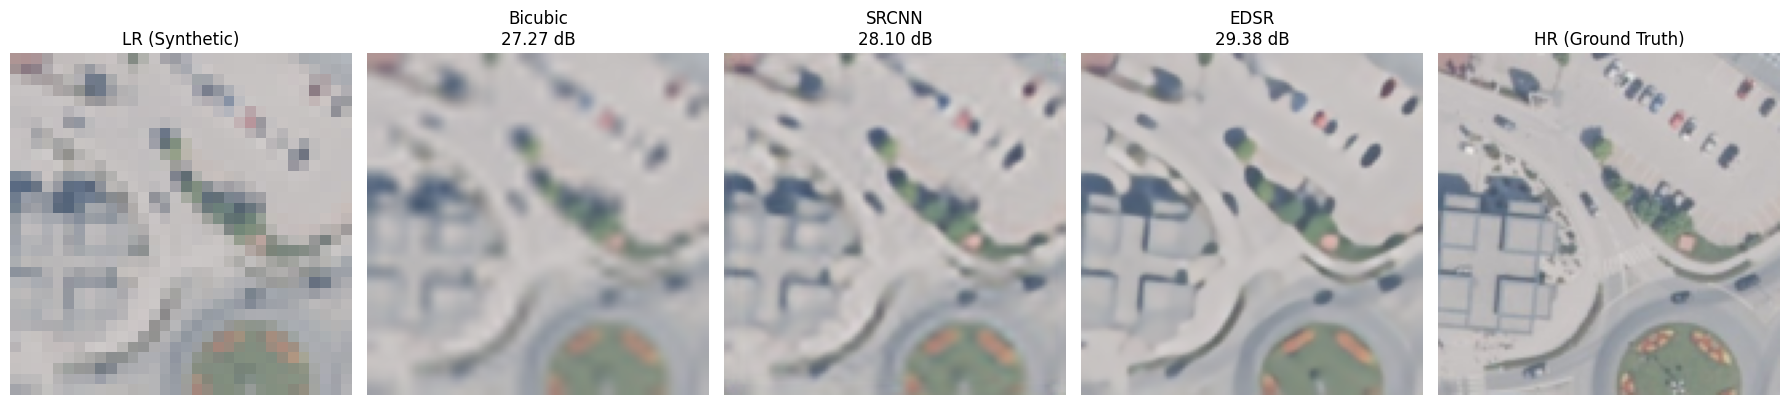

In [9]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/tyrol-e19_r14_c13.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

 PSNR RESULTS (Synthetic LR)
  Bicubic : 24.83 dB
  SRCNN   : 25.66 dB
  EDSR    : 26.49 dB


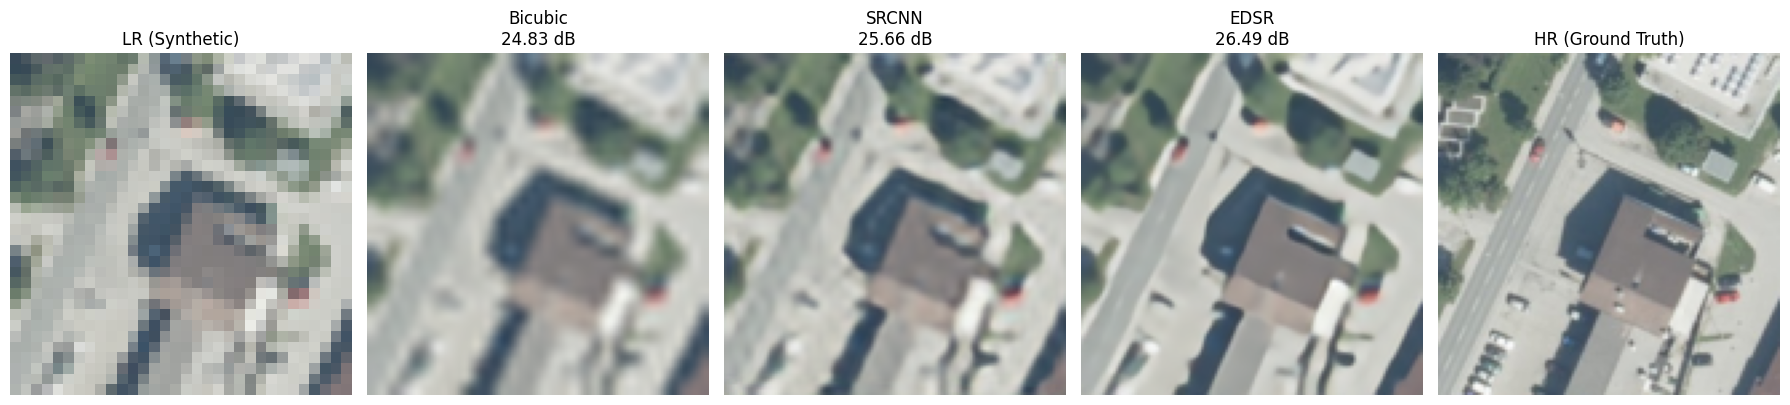

In [11]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/tyrol-w28_r22_c22.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

 PSNR RESULTS (Synthetic LR)
  Bicubic : 27.61 dB
  SRCNN   : 28.86 dB
  EDSR    : 29.35 dB


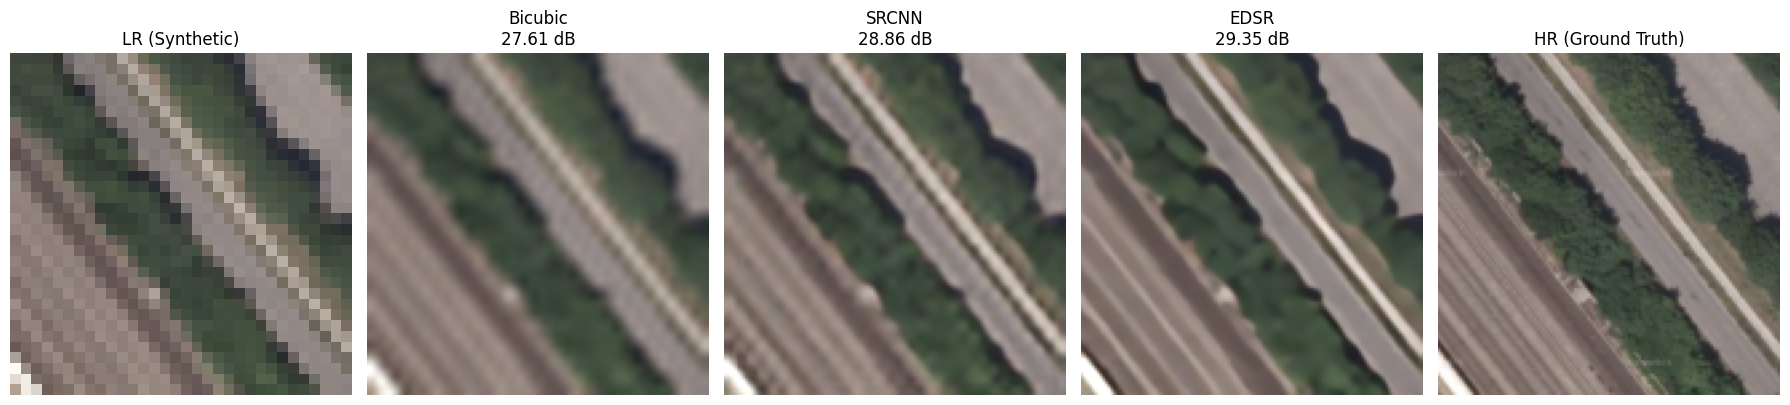

In [12]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/vienna36_r22_c19.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

In [14]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch 
import torch.nn as nn
import torch.optim as optim

from importlib import reload    
import src.utils.config
reload(src.utils.config)
from src.utils.config import CONFIG

from src.utils.data_loader import create_loaders
from src.utils.models_architecture import EDSR       
from src.utils.train_model_sr import train_model_sr

best_model_path = CONFIG["model"]["best_EDSR_path"]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = 32 #CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = 20 #CONFIG["training"]["epochs"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]


best_model_path = CONFIG["model"]["best_EDSR_path"]
last_model_path = CONFIG["model"]["last_EDSR_path"]

history_path = CONFIG["history"]["EDSR_history_path"]

# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)

model = EDSR().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device : cuda

 DATA LOADED:
  Train: 152352 samples
  Val:   19044 samples
  Test:  19044 samples
